# MULTIGRIS ISM applications
## Use power-law/normal distributions

<font color=red>For best performance, it is advised to execute MULTIGRIS in the shell, as explained in the README. This notebook is just a way to illustrate a workflow. </font>

***
This notebook presents some examples of ISM applications with MULTIGRIS. <font color=red>Make sure to check the general notebooks on how to run the programs beforehand!</font>

We'll also take the occasion to use various plots and inference options. 

The applications will use the following Cloudy grid (Ferland et al. [2017](https://ui.adsabs.harvard.edu/abs/2017RMxAA..53..385F/abstract)):
- LOC

The various notebooks use some specific terms described in the file TERMS.org. 
***

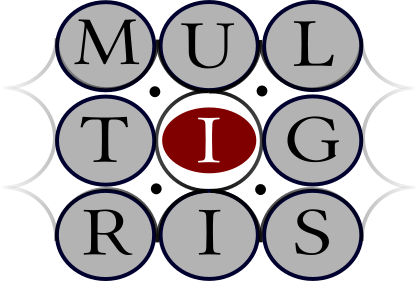

In [1]:
%load_ext autoreload
%autoreload 2
from wand.image import Image as WImage #this is to view PDFs
from IPython.display import Image
Image(filename='../Images/logo.png')

## Table of contents:
* [Parameters and syntax](#app1)
* [Use a power-law](#app2)

## Imports and settings
***

In [2]:
import os

import sys
sys.path.append('../') 

#arviz to read the PyMC3 trace
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

#imports to make input files
import importlib
import Library.lib_input
importlib.reload(Library.lib_input)
from Library.lib_input import *

#import the main MULTIGRIS scripts
import mgris_search, mgris_process, mgris_post_process, mgris_compare

#may need to run this if the script is interrupted
from Library.lib_main import closelogfiles
from Library.lib_mc import distrib_plaw, distrib_brokenplaw, distrib_smoothplaw, distrib_normal, distrib_dnormal

# global parameters
from rcparams import rcParams

#to read the grid
import pandas as pd

#this is the input filename we'll use throughout, it will be automatically copied in the output directories each run
os.makedirs('./Runs/ISM_applications', exist_ok=True)
inputfile = './Runs/ISM_applications/input.txt' 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
if rcParams['inference_backend']=='gpu':
    import jax
    jax.clear_caches()

Checking path in case several copies exist

In [4]:
mgris_search.__file__

'/local/home/vleboute/work/MULTIGRIS/mgris/mgris_search.py'

## Parameters and syntax <a class="anchor" id="app1"></a>
***

We describe below the various distributions implemented in MULTIGRIS. 

Instead of using the primary parameter from the grid as is, it is possible to consider a distribution by summing the models in the grid according to some weights that depend on the grid parameter value. 

For a model table with parameters $\theta$ and observations O:

<table style='border-spacing: 0px;border: 1px solid;text-align:left;' width=800>
    <tr style='border: 1px solid;'>
        <th>Parameter 1</th><th>Parameter 2</th><th>...</th><th>...</th><th></th><th>Observable 1</th><th>Observable 2</th><th>...</th><th>...</th>        
    </tr>
    <tr style='border: 1px solid;'>
        <td>$\theta_{0,0}$</td><td>$\theta_{1,0}$</td><td></td><td>$\theta_{n_{params},0}$</td><td></td><td>$O_{0,0}$</td><td>$O_{1,0}$</td><td></td><td>$O_{n_{obs},0}$</td>
    </tr>
    <tr style='border: 1px solid;'>
        <td>$\theta_{0,1}$</td><td>$\theta_{1,1}$</td><td></td><td>$\theta_{n,1}$</td><td></td><td>$O_{0,1}$</td><td>$O_{1,1}$</td><td></td><td>$O_{N,1}$</td>
    </tr>
    <tr style='border: 1px solid;'>
        <td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
    </tr>
    <tr style='border: 1px solid;'>
        <td>$\theta_{0,n_{models}}$</td><td>$\theta_{1,n_{models}}$</td><td></td><td>$\theta_{n,n_{models}}$</td><td></td><td>$O_{0,n_{models}}$</td><td>$O_{1,n_{models}}$</td><td></td><td>$O_{n_{obs},n_{models}}$</td>
    </tr>
<table>

Each observation value can then be multiplied by a weight (according to a pre-defined distribution, see below) that is a function of $\theta$ and we obtain the sum (last row)

<table style='border-spacing: 0px;border: 1px solid;text-align:left;' width=1200>
    <tr style='border: 1px solid;'>
        <th>Parameter 1</th><th>Parameter 2</th><th>...</th><th>...</th><th></th><th>Observable 1</th><th>Observable 2</th><th>...</th><th>...</th>        
    </tr>
    <tr style='border: 1px solid;'>
        <td>$\theta_{0,0}$</td><td>$\theta_{1,0}$</td><td></td><td>$\theta_{n_{params},0}$</td><td></td><td>$O_{0,0} \times f(\theta_{*,0})$</td><td>$O_{1,0} \times f(\theta_{*,0})$</td><td></td><td>$O_{n_{obs},0} \times f(\theta_{*,0})$</td>
    </tr>
    <tr style='border: 1px solid;'>
        <td>$\theta_{0,1}$</td><td>$\theta_{1,1}$</td><td></td><td>$\theta_{n,1}$</td><td></td><td>$O_{0,1} \times f(\theta_{*,1})$</td><td>$O_{1,1} \times f(\theta_{*,1})$</td><td></td><td>$O_{N,1} \times f(\theta_{*,1})$</td>
    </tr>
    <tr style='border: 1px solid;'>
        <td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
    </tr>
    <tr style='border: 1px solid;'>
        <td>$\theta_{0,n_{models}}$</td><td>$\theta_{1,n_{models}}$</td><td></td><td>$\theta_{n,n_{models}}$</td><td></td><td>$O_{0,n_{models}} \times f(\theta_{*,n_{models}})$</td><td>$O_{1,n_{models}} \times f(\theta_{*,n_{models}})$</td><td></td><td>$O_{n_{obs},n_{models}} \times f(\theta_{*,n_{models}})$</td>
    </tr>
    <tr>
        <td></td><td></td><td></td><td></td><td></td><td>$\Sigma_i O_{0,i} \times f(\theta_{*,i})$</td><td>$\Sigma_i O_{1,i} \times f(\theta_{*,i})$</td><td></td><td>$\Sigma_i O_{n_{obs},i} \times f(\theta_{*,i})$</td>
    </tr>
<table>

## Power-law

- Use 'distrib {p} plaw' in BEGIN configuration block or in pre-defined configuration (context directory)
- Power-law parameters: alpha_{p}, lowerbound_{p}, and upperbound_{p}

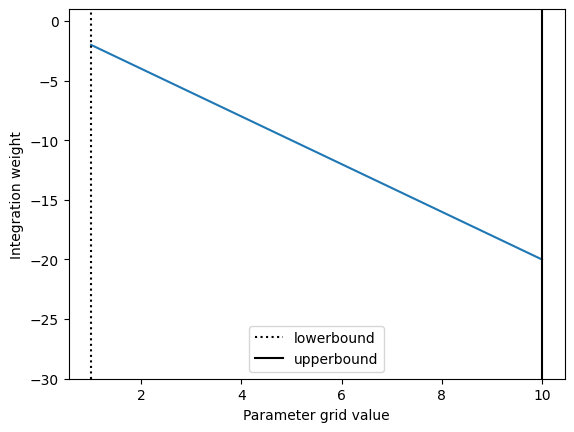

In [5]:
boundaries = [1, 10]
alpha = -3
x, weight = distrib_plaw(boundaries, alpha)
fig, ax = plt.subplots(1, 1)
ax.plot(x,weight)
ax.set_ylim([-30, 1])
ax.axvline(boundaries[0], color="black", ls=':', label='lowerbound')
ax.axvline(boundaries[1], color="black", label='upperbound')
ax.set_xlabel('Parameter grid value')
ax.set_ylabel('Integration weight')
ax.legend()
plt.show()

## Smooth power-law

- Use 'distrib {p} smoothplaw' in BEGIN configuration block or in pre-defined configuration (context directory)
- Power-law parameters: alpha_{p}, lowerbound_{p}, upperbound_{p}, lowerscale_{p}, upperscale_{p}

The smooth power-law distribution includes exponential turn-on and cut-off with the new random variable _lowerscale_ and _upperscale_:

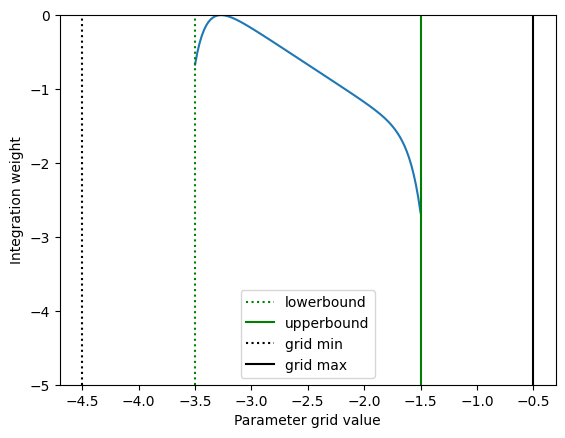

In [6]:
boundaries = [-4.5, -0.5]
cuts = [-3.5, -1.5]
alpha = -2
scales = [1, 1]
x, weight = distrib_smoothplaw(cuts, alpha, scales)
fig, ax = plt.subplots(1, 1)
ax.plot(x, weight-weight.max(),)
ax.set_ylim([-5, 0])
ax.axvline(cuts[0], ls=':', color='green', label='lowerbound')
ax.axvline(cuts[1], color='green', label='upperbound')
ax.axvline(boundaries[0], color="black", ls=':', label='grid min')
ax.axvline(boundaries[1], color="black", label='grid max')
ax.set_xlabel('Parameter grid value')
ax.set_ylabel('Integration weight')
ax.legend()
plt.show()

## Broken power-law

- Use 'distrib {p} brokenplaw' in BEGIN configuration block or in pre-defined configuration (context directory)
- Broken power-law parameters: alpha1_{p}, pivot_{p}, alpha2_{p}, lowerbound_{p}, and upperbound_{p}

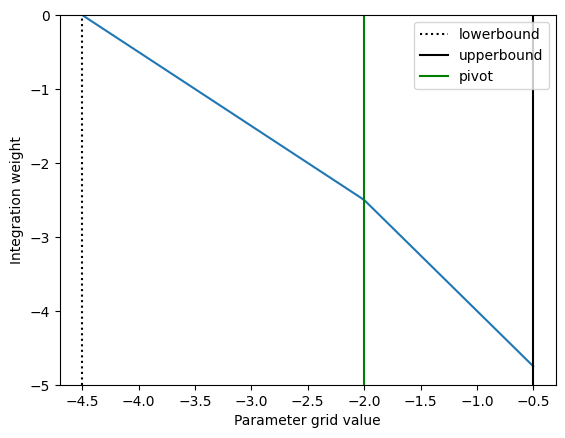

In [7]:
boundaries = [-4.5, -0.5]
alphas = [-2, -2.5]
pivot = -2
x, weight = distrib_brokenplaw(boundaries, alphas, pivot)
fig, ax = plt.subplots(1, 1)
ax.plot(x, weight-weight.max(),)
ax.set_ylim([-5, 0])
ax.axvline(boundaries[0], color="black", ls=':', label='lowerbound')
ax.axvline(boundaries[1], color="black", label='upperbound')
ax.axvline(pivot, color="green", label='pivot')
ax.set_xlabel('Parameter grid value')
ax.set_ylabel('Integration weight')
ax.legend()
plt.show()

## Normal

- Use 'distrib {p} normal' in BEGIN configuration block or in pre-defined configuration (context directory)
- Normal law parameters: mu_{p}, sigma_{p}, lowerbound_{p}, and upperbound_{p}

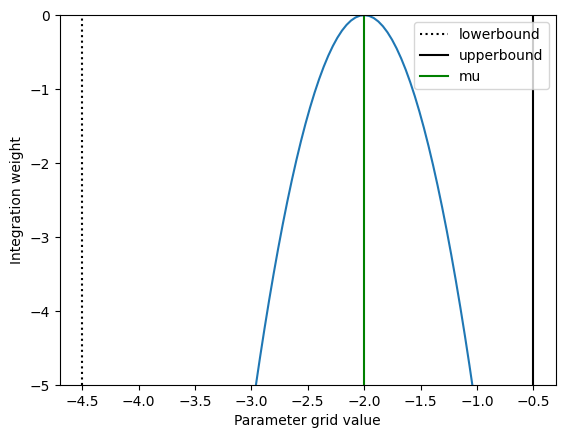

In [8]:
boundaries = [-4.5, -0.5]
mu, sigma = -2, 0.2
x, weight = distrib_normal(boundaries, mu, sigma)
fig, ax = plt.subplots(1, 1)
ax.plot(x, weight-weight.max(),)
ax.set_ylim([-5, 0])
ax.axvline(boundaries[0], color="black", ls=':', label='lowerbound')
ax.axvline(boundaries[1], color="black", label='upperbound')
ax.axvline(mu, color="green", label='mu')
ax.set_xlabel('Parameter grid value')
ax.set_ylabel('Integration weight')
ax.legend()
plt.show()

Note that _mu_ is allowed to be outside the boundaries

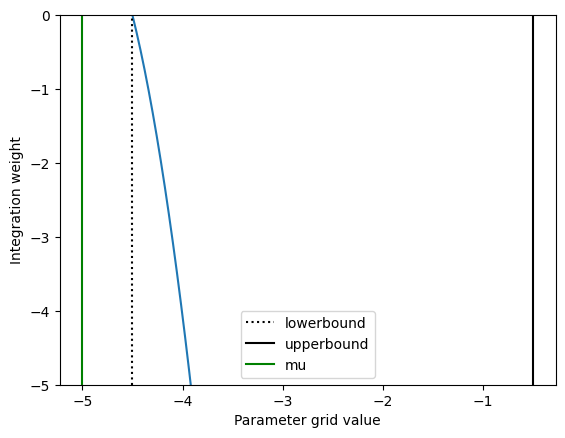

In [9]:
boundaries = [-4.5, -0.5]
mu, sigma = -5, 0.2
x, weight = distrib_normal(boundaries, mu, sigma)
fig, ax = plt.subplots(1, 1)
ax.plot(x, weight-weight.max(),)
ax.set_ylim([-5, 0])
ax.axvline(boundaries[0], color="black", ls=':', label='lowerbound')
ax.axvline(boundaries[1], color="black", label='upperbound')
ax.axvline(mu, color="green", label='mu')
ax.set_xlabel('Parameter grid value')
ax.set_ylabel('Integration weight')
ax.legend()
plt.show()

## Double-normal

- Use 'distrib {p} doublenormal' in BEGIN configuration block or in pre-defined configuration (context directory)
- Double normal law parameters: mu1_{p}, sigma1_{p}, mu2_{p}, sigma2_{p}, ratio21_{p}, lowerbound_{p}, and upperbound_{p}
- ratio21 is the log of the ratio between component 2 and component 1

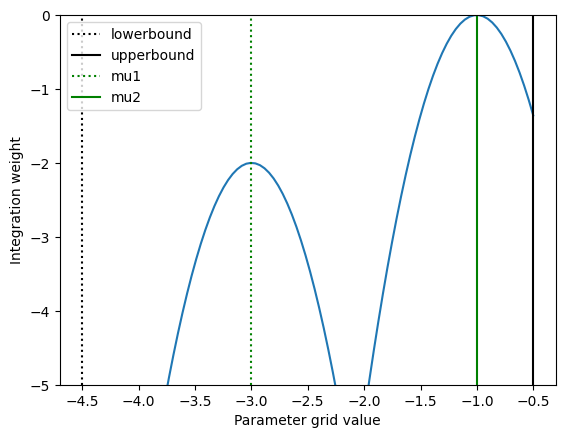

In [10]:
boundaries = [-4.5, -0.5]
mus = [-3, -1]
sigmas = [0.2, 0.2]
ratio21 = 2
x, weight = distrib_dnormal(boundaries, mus, sigmas, ratio21)
fig, ax = plt.subplots(1, 1)
ax.plot(x, weight-weight.max(),)
ax.set_ylim([-5, 0])
ax.axvline(boundaries[0], color="black", ls=':', label='lowerbound')
ax.axvline(boundaries[1], color="black", label='upperbound')
ax.axvline(mus[0], color="green", ls=':', label='mu1')
ax.axvline(mus[1], color="green", label='mu2')
ax.set_xlabel('Parameter grid value')
ax.set_ylabel('Integration weight')
ax.legend()
plt.show()

Note that a double-normal law cannot reproduce the results of a 2-sector model because for the latter the bimodality is in the *set* of parameters

## Priors on distribution random variables

 In BEGIN configuration block as usual, for each random variable:
 - = value
 - = value sdev
 - = value sdev min max

## Application <a class="anchor" id="app2"></a>
***

In [11]:
params = get_params()
params['context'].value = 'Contexts/mgris_loc/Single'
output_directory = './Runs/ISM_applications/powerlaw/'

params['output'].value = output_directory

#params['select'].value = ['AGNFRAC [0,0]' ]#, 'Z [0.398,0.398]']

# we will use a nearest neighbor interpolation for Z and power-law distributions for U and n
params['BEGIN configuration'].value = '''distrib U plaw
alpha_U_0 = -3.5 0.1
lowerbound_U_0 = -4
upperbound_U_0 = -2
distrib n plaw
alpha_n_0 = -2 0.1
lowerbound_n_0 = 1
upperbound_n_0 = 4
distrib Z single nearest
'''

# we use values from a grid that computed the power-law distribution already and add a 5% uncertainty
params['BEGIN observations'].value = '''C__2_157636m 674926235.0867414 0.05*674926235
N__2_121767m 140475623.8431249 0.05*140475623
N__2_205244m 129608435.1301557 0.05*129608435
N__3_573238m 8148712.2179534305 0.05*8148712
O__1_631679m 43781271.01290078 0.05*43781271
O__1_145495m 3702592.36220644 0.05*3702592
O__3_518004m 7250408.458056196 0.05*7250408
O__3_883323m 12118005.210883038 0.05*12118005
O__4_258832m 73.7499823258302 0.05*73
NE_2_128101m 373090144.1588963 0.05*373090144
NE_3_155509m 12278532.218636138 0.05*12278532'''
params['BEGIN observations'].extras = {'scale': 'linear'} 

params['use_scaling'].value = "'all'"

make_input(params, inputfile)

For now power-law distributions are only available for a single sector, and a nearest neighbor interpolation is used for the parameters that don't have a power-law distribution

In [12]:
if rcParams['inference_backend']=='gpu':
    nsamples_per_job = 150
else:
    nsamples_per_job = 500
    
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, nsamples_per_job=nsamples_per_job))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓



    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.2
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor.NOBACKUP
    ┝ - Precision: float32
    ┕========================================
    

    ┍=

[11 14 17  8 16  4]
-> [11  1 17  8 16  4]
-> [11  1 17  8 16  4]
-> [11  1 17  8 16  4]
[11  1 17  8 16  4]


AGNFRAC 0: single value (nearest neighbor grid interpolation)


-> [11  1 17  8  1  4]
[11  1 17  8  1  4]


U 0: distribution (power-law, normal...)


-> [11  1 17  8  1  1]
[11  1 17  8  1  1]


n 0: distribution (power-law, normal...)


-> (example)  [11  1  9  8  1  1]
[11  1  9  8  1  1]
-> (example)  [11  1  9  7  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [alpha_U_0, alpha_n_0, idx_AGNFRAC_0, idx_Z_0, idx_age_0, scale]
Sampling: [alpha_U_0, alpha_n_0, idx_AGNFRAC_0, idx_Z_0, idx_age_0, scale]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                        mean        sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_U_0             -3.503     0.103    -3.688   -3.301      0.004    0.003   
alpha_n_0             -2.006     0.102    -2.189   -1.813      0.005    0.003   
idx_AGNFRAC_0          1.472     0.831     0.016    2.803      0.039    0.028   
idx_Z_0                6.426     3.622     0.508   12.265      0.166    0.118   
idx_age_0              7.338     3.933     0.359   13.751      0.171    0.122   
idx_lowerbound_U_0     2.000     0.000     2.000    2.000      0.000    0.000   
idx_lowerbound_n_0     1.000     0.000     1.000    1.000      0.000    0.000   
idx_upperbound_U_0    


✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-09-06 20:38:47.619577
Time used           : 1.7 min.
Sampling time used  :  1.02 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 560599 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_U_0                -3.449  0.056  -3.560   -3.348      0.001    0.001   
alpha_n_0                -1.989  0.078  -2.131   -1.834      0.002    0.001   
idx_AGNFRAC_0             0.262  0.140   0.043    0.499      0.003    0.002   
idx_Z_0                  10.996  0.287  10.505   11.437      0.007    0.005   
idx_age_0                 5.220  0.496   4.504    6

In [13]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓









    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 20:38:49
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/powerlaw/
    ┕========================================┙
    
List of tracers whose detection level devia

In [14]:
%cat $output_directory/results.txt


                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha_U_0           -3.449  0.056  -3.563   -3.348      0.002    0.001    1130.0     908.0   1.00
alpha_n_0           -1.988  0.077  -2.131   -1.839      0.003    0.002     866.0     954.0   1.01
idx_AGNFRAC_0        0.264  0.139   0.048    0.499      0.004    0.003     998.0     951.0   1.00
idx_Z_0             11.006  0.286  10.521   11.449      0.009    0.007     936.0    1030.0   1.00
idx_age_0            5.206  0.492   4.504    6.206      0.016    0.011    1025.0    1084.0   1.00
idx_lowerbound_U_0   2.000  0.000   2.000    2.000      0.000    0.000    1000.0    1000.0    NaN
idx_lowerbound_n_0   1.000  0.000   1.000    1.000      0.000    0.000    1000.0    1000.0    NaN
idx_upperbound_U_0  10.000  0.000  10.000   10.000      0.000    0.000    1000.0    1000.0    NaN
idx_upperbound_n_0   7.000  0.000   7.000    7.000      0.000    0.000    1000.0    1000.0    NaN
scale              